In [1]:
import torch
import torchvision
from torchvision import transforms, datasets, models
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.image as mpimg
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from models import Net
from sklearn.metrics import f1_score
import numpy as np
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2', 'class 3', 'class 4', 'class 5']

In [2]:
num_classes = 5

data_dir = '/home/karan/python/analytics_vidhya/train1/'

data_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.Pad((2,2)), transforms.RandomAffine(60), transforms.RandomCrop((196, 196)), transforms.RandomHorizontalFlip(0.5), transforms.RandomVerticalFlip(0.5), transforms.ColorJitter(), transforms.CenterCrop((156,156)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225]) ])

image_datasets = datasets.ImageFolder(os.path.join(data_dir), data_transforms)

dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size = 64, shuffle = True)


In [3]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    """mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)"""

    plt.imshow(inp,cmap)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


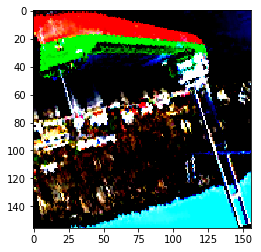

In [4]:
imshow(image_datasets[0][0])

In [5]:
dataset_sizes = len(image_datasets)
class_names = image_datasets.classes
print(dataset_sizes)
print(class_names)

6252
['1', '2', '3', '4', '5']


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [7]:
def train_model(model, criterion, optimizer, num_epochs = 10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-'*10)
        
        l = []
        p = []
        
        model.train()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            
            
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            #running_corrects += f1_score(labels.data.cpu(), preds.cpu(), average='weighted') 
            labels = labels.tolist()
            preds = preds.tolist()
            l.extend(labels)
            p.extend(preds)
            
        epoch_loss = running_loss / dataset_sizes
        #epoch_acc = np.float32(running_corrects) / dataset_sizes
        epoch_acc = running_corrects.double() / dataset_sizes
        
        print('Loss : {:.6f} Acc : {:.6f}'.format(epoch_loss, epoch_acc))
        print(classification_report(l, p, target_names=target_names))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'best_model_wts.pth')


    print()

    time_elapsed = time.time() - since
    
    print('Training Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc : {:6f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

    return model

In [8]:
model_ft = models.resnet34(pretrained=True)

for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       num_epochs=200)

Epoch 1/200
----------
Loss : 1.092591 Acc : 0.609725
              precision    recall  f1-score   support

     class 1       0.61      0.65      0.63      2120
     class 2       0.66      0.68      0.67      1167
     class 3       0.66      0.65      0.66       916
     class 4       0.62      0.59      0.61       832
     class 5       0.50      0.45      0.48      1217

    accuracy                           0.61      6252
   macro avg       0.61      0.61      0.61      6252
weighted avg       0.61      0.61      0.61      6252

Epoch 2/200
----------
Loss : 0.770170 Acc : 0.706014
              precision    recall  f1-score   support

     class 1       0.66      0.70      0.68      2120
     class 2       0.76      0.78      0.77      1167
     class 3       0.80      0.80      0.80       916
     class 4       0.79      0.77      0.78       832
     class 5       0.59      0.53      0.56      1217

    accuracy                           0.71      6252
   macro avg       0.72

Loss : 0.759846 Acc : 0.725688
              precision    recall  f1-score   support

     class 1       0.70      0.71      0.71      2120
     class 2       0.77      0.79      0.78      1167
     class 3       0.83      0.84      0.84       916
     class 4       0.78      0.79      0.78       832
     class 5       0.60      0.56      0.58      1217

    accuracy                           0.73      6252
   macro avg       0.74      0.74      0.74      6252
weighted avg       0.72      0.73      0.72      6252

Epoch 18/200
----------
Loss : 0.841955 Acc : 0.717210
              precision    recall  f1-score   support

     class 1       0.70      0.71      0.70      2120
     class 2       0.78      0.79      0.78      1167
     class 3       0.80      0.80      0.80       916
     class 4       0.79      0.78      0.79       832
     class 5       0.57      0.56      0.57      1217

    accuracy                           0.72      6252
   macro avg       0.73      0.73      0.73  

Loss : 0.796737 Acc : 0.734645
              precision    recall  f1-score   support

     class 1       0.71      0.73      0.72      2120
     class 2       0.77      0.80      0.79      1167
     class 3       0.83      0.82      0.83       916
     class 4       0.79      0.78      0.79       832
     class 5       0.63      0.59      0.60      1217

    accuracy                           0.73      6252
   macro avg       0.75      0.74      0.74      6252
weighted avg       0.73      0.73      0.73      6252

Epoch 34/200
----------
Loss : 0.784857 Acc : 0.738964
              precision    recall  f1-score   support

     class 1       0.71      0.72      0.71      2120
     class 2       0.80      0.81      0.80      1167
     class 3       0.85      0.85      0.85       916
     class 4       0.80      0.82      0.81       832
     class 5       0.60      0.56      0.58      1217

    accuracy                           0.74      6252
   macro avg       0.75      0.75      0.75  

Loss : 0.779877 Acc : 0.735765
              precision    recall  f1-score   support

     class 1       0.71      0.73      0.72      2120
     class 2       0.77      0.77      0.77      1167
     class 3       0.84      0.84      0.84       916
     class 4       0.79      0.79      0.79       832
     class 5       0.62      0.59      0.61      1217

    accuracy                           0.74      6252
   macro avg       0.75      0.75      0.75      6252
weighted avg       0.74      0.74      0.74      6252

Epoch 50/200
----------
Loss : 0.780488 Acc : 0.733685
              precision    recall  f1-score   support

     class 1       0.70      0.71      0.71      2120
     class 2       0.80      0.81      0.81      1167
     class 3       0.85      0.84      0.85       916
     class 4       0.79      0.80      0.79       832
     class 5       0.59      0.57      0.58      1217

    accuracy                           0.73      6252
   macro avg       0.75      0.75      0.75  

Loss : 0.855884 Acc : 0.722009
              precision    recall  f1-score   support

     class 1       0.71      0.72      0.71      2120
     class 2       0.79      0.80      0.79      1167
     class 3       0.82      0.82      0.82       916
     class 4       0.77      0.77      0.77       832
     class 5       0.57      0.55      0.56      1217

    accuracy                           0.72      6252
   macro avg       0.73      0.73      0.73      6252
weighted avg       0.72      0.72      0.72      6252

Epoch 66/200
----------
Loss : 0.868613 Acc : 0.714491
              precision    recall  f1-score   support

     class 1       0.68      0.71      0.70      2120
     class 2       0.78      0.80      0.79      1167
     class 3       0.83      0.82      0.83       916
     class 4       0.78      0.77      0.77       832
     class 5       0.57      0.53      0.55      1217

    accuracy                           0.71      6252
   macro avg       0.73      0.72      0.73  

Loss : 0.768436 Acc : 0.739443
              precision    recall  f1-score   support

     class 1       0.71      0.72      0.72      2120
     class 2       0.79      0.81      0.80      1167
     class 3       0.84      0.83      0.83       916
     class 4       0.79      0.80      0.79       832
     class 5       0.62      0.58      0.60      1217

    accuracy                           0.74      6252
   macro avg       0.75      0.75      0.75      6252
weighted avg       0.74      0.74      0.74      6252

Epoch 82/200
----------
Loss : 0.765440 Acc : 0.733205
              precision    recall  f1-score   support

     class 1       0.71      0.73      0.72      2120
     class 2       0.79      0.80      0.79      1167
     class 3       0.84      0.83      0.83       916
     class 4       0.79      0.78      0.79       832
     class 5       0.60      0.58      0.59      1217

    accuracy                           0.73      6252
   macro avg       0.75      0.74      0.74  

Loss : 0.926492 Acc : 0.714491
              precision    recall  f1-score   support

     class 1       0.70      0.72      0.71      2120
     class 2       0.75      0.78      0.77      1167
     class 3       0.79      0.79      0.79       916
     class 4       0.80      0.79      0.79       832
     class 5       0.58      0.55      0.57      1217

    accuracy                           0.71      6252
   macro avg       0.72      0.72      0.72      6252
weighted avg       0.71      0.71      0.71      6252

Epoch 98/200
----------
Loss : 0.830319 Acc : 0.731926
              precision    recall  f1-score   support

     class 1       0.72      0.73      0.72      2120
     class 2       0.78      0.80      0.79      1167
     class 3       0.81      0.81      0.81       916
     class 4       0.78      0.79      0.78       832
     class 5       0.61      0.57      0.59      1217

    accuracy                           0.73      6252
   macro avg       0.74      0.74      0.74  

Loss : 0.814364 Acc : 0.729367
              precision    recall  f1-score   support

     class 1       0.70      0.71      0.71      2120
     class 2       0.79      0.80      0.80      1167
     class 3       0.85      0.84      0.84       916
     class 4       0.79      0.79      0.79       832
     class 5       0.59      0.56      0.58      1217

    accuracy                           0.73      6252
   macro avg       0.74      0.74      0.74      6252
weighted avg       0.73      0.73      0.73      6252

Epoch 114/200
----------
Loss : 0.888858 Acc : 0.714012
              precision    recall  f1-score   support

     class 1       0.69      0.70      0.70      2120
     class 2       0.77      0.78      0.77      1167
     class 3       0.81      0.81      0.81       916
     class 4       0.80      0.79      0.80       832
     class 5       0.57      0.54      0.55      1217

    accuracy                           0.71      6252
   macro avg       0.73      0.73      0.73 

Loss : 0.787474 Acc : 0.736884
              precision    recall  f1-score   support

     class 1       0.71      0.73      0.72      2120
     class 2       0.78      0.81      0.79      1167
     class 3       0.83      0.83      0.83       916
     class 4       0.79      0.79      0.79       832
     class 5       0.62      0.58      0.60      1217

    accuracy                           0.74      6252
   macro avg       0.75      0.75      0.75      6252
weighted avg       0.74      0.74      0.74      6252

Epoch 130/200
----------
Loss : 0.747951 Acc : 0.743282
              precision    recall  f1-score   support

     class 1       0.72      0.73      0.72      2120
     class 2       0.79      0.81      0.80      1167
     class 3       0.83      0.84      0.83       916
     class 4       0.82      0.83      0.82       832
     class 5       0.62      0.57      0.59      1217

    accuracy                           0.74      6252
   macro avg       0.75      0.76      0.75 

Loss : 0.802513 Acc : 0.735925
              precision    recall  f1-score   support

     class 1       0.71      0.73      0.72      2120
     class 2       0.79      0.82      0.81      1167
     class 3       0.80      0.79      0.80       916
     class 4       0.80      0.80      0.80       832
     class 5       0.62      0.58      0.60      1217

    accuracy                           0.74      6252
   macro avg       0.75      0.75      0.75      6252
weighted avg       0.73      0.74      0.73      6252

Epoch 146/200
----------
Loss : 0.800808 Acc : 0.733205
              precision    recall  f1-score   support

     class 1       0.71      0.73      0.72      2120
     class 2       0.76      0.78      0.77      1167
     class 3       0.83      0.83      0.83       916
     class 4       0.79      0.80      0.79       832
     class 5       0.62      0.58      0.60      1217

    accuracy                           0.73      6252
   macro avg       0.74      0.74      0.74 

Loss : 0.813900 Acc : 0.733365
              precision    recall  f1-score   support

     class 1       0.71      0.73      0.72      2120
     class 2       0.78      0.80      0.79      1167
     class 3       0.81      0.82      0.81       916
     class 4       0.79      0.78      0.79       832
     class 5       0.62      0.58      0.60      1217

    accuracy                           0.73      6252
   macro avg       0.74      0.74      0.74      6252
weighted avg       0.73      0.73      0.73      6252

Epoch 162/200
----------
Loss : 0.834342 Acc : 0.726647
              precision    recall  f1-score   support

     class 1       0.70      0.72      0.71      2120
     class 2       0.79      0.80      0.80      1167
     class 3       0.82      0.83      0.82       916
     class 4       0.77      0.77      0.77       832
     class 5       0.60      0.57      0.59      1217

    accuracy                           0.73      6252
   macro avg       0.74      0.74      0.74 

Loss : 0.804166 Acc : 0.731606
              precision    recall  f1-score   support

     class 1       0.72      0.73      0.72      2120
     class 2       0.77      0.79      0.78      1167
     class 3       0.80      0.82      0.81       916
     class 4       0.79      0.79      0.79       832
     class 5       0.62      0.58      0.60      1217

    accuracy                           0.73      6252
   macro avg       0.74      0.74      0.74      6252
weighted avg       0.73      0.73      0.73      6252

Epoch 178/200
----------
Loss : 0.846942 Acc : 0.721049
              precision    recall  f1-score   support

     class 1       0.69      0.71      0.70      2120
     class 2       0.79      0.81      0.80      1167
     class 3       0.82      0.81      0.82       916
     class 4       0.80      0.79      0.79       832
     class 5       0.58      0.55      0.57      1217

    accuracy                           0.72      6252
   macro avg       0.73      0.73      0.73 

Loss : 0.766352 Acc : 0.735765
              precision    recall  f1-score   support

     class 1       0.71      0.73      0.72      2120
     class 2       0.77      0.80      0.78      1167
     class 3       0.84      0.85      0.85       916
     class 4       0.79      0.79      0.79       832
     class 5       0.61      0.56      0.59      1217

    accuracy                           0.74      6252
   macro avg       0.75      0.75      0.75      6252
weighted avg       0.73      0.74      0.73      6252

Epoch 194/200
----------
Loss : 0.855110 Acc : 0.728087
              precision    recall  f1-score   support

     class 1       0.70      0.72      0.71      2120
     class 2       0.79      0.80      0.79      1167
     class 3       0.84      0.84      0.84       916
     class 4       0.78      0.77      0.78       832
     class 5       0.59      0.56      0.58      1217

    accuracy                           0.73      6252
   macro avg       0.74      0.74      0.74 

In [10]:
test_dir = '/home/karan/python/analytics_vidhya/test/1/'

In [11]:
class ImageDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform = None):
        self.class_labels = pd.read_csv('test_ApKoW4T.csv')
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.class_labels)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, self.class_labels.iloc[idx, 0])
        image = Image.open(image_name)
        image = image.convert('RGB')

        """if image.size[0] != 3:
            pass"""
        sample = {'image': image, 'image_name' : self.class_labels.iloc[idx, 0]}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])
            
        return sample

In [12]:
test_data_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.Pad((2,2)), transforms.RandomCrop((196, 196)), transforms.CenterCrop((156,156)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225]) ])
test_dataset = ImageDataset('test_ApKoW4T.csv', test_dir, test_data_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True,  num_workers=6)

In [13]:
name = []
prediction = []
model_ft.eval()
for sample in test_loader:
    image = sample['image'].to(device)
    outputs = model_ft(image)
    _, predicted = torch.max(outputs, 1) 
    print(sample['image_name'], predicted.item() + 1)
    name.append(sample['image_name'])
    prediction.append(predicted.item() + 1)

['2668080.jpg'] 2
['2633994.jpg'] 2
['2849910.jpg'] 5
['2796385.jpg'] 1
['2890406.jpg'] 3
['2838084.jpg'] 3
['619975.jpg'] 5
['2904716.jpg'] 1
['2848422.jpg'] 3
['2808682.jpg'] 5
['1868917.jpg'] 4
['2780162.jpg'] 1
['2885795.jpg'] 3
['2796393.jpg'] 1
['2900551.jpg'] 1
['2858058.jpg'] 5
['2816902.jpg'] 5
['2902672.jpg'] 5
['2312089.jpg'] 4
['2875153.jpg'] 3
['2843604.jpg'] 5
['2859565.jpg'] 3
['625354.jpg'] 4
['2792310.jpg'] 1
['2877291.jpg'] 2
['2892016.jpg'] 3
['2782247.jpg'] 1
['2833375.jpg'] 2
['2829222.jpg'] 1
['2837306.jpg'] 3
['2835401.jpg'] 1
['2806722.jpg'] 1
['2827201.jpg'] 1
['2845732.jpg'] 1
['2788255.jpg'] 5
['2884340.jpg'] 5
['2902636.jpg'] 1
['2816869.jpg'] 1
['1980440.jpg'] 4
['2902797.jpg'] 2
['2860051.jpg'] 5
['1796428.jpg'] 4
['2812836.jpg'] 1
['2826673.jpg'] 2
['2792386.jpg'] 1
['2841877.jpg'] 3
['2798358.jpg'] 1
['1903824.jpg'] 4
['1703091.jpg'] 4
['2866089.jpg'] 1
['2835511.jpg'] 1
['2360965.jpg'] 4
['2855957.jpg'] 1
['2870051.jpg'] 5
['2784213.jpg'] 1
['2720154.jp

['2833351.jpg'] 1
['2782139.jpg'] 3
['2861728.jpg'] 3
['2802494.jpg'] 1
['2864136.jpg'] 1
['2823125.jpg'] 5
['2386164.jpg'] 4
['951046.jpg'] 4
['2812767.jpg'] 1
['2859433.jpg'] 3
['2908130.jpg'] 3
['2812854.jpg'] 1
['1263061.jpg'] 4
['2870045.jpg'] 5
['2782260.jpg'] 5
['2790348.jpg'] 1
['2669738.jpg'] 2
['2847444.jpg'] 3
['2890499.jpg'] 5
['2843756.jpg'] 1
['2237388.jpg'] 4
['2856031.jpg'] 1
['2808791.jpg'] 1
['2884424.jpg'] 5
['2857966.jpg'] 1
['2823230.jpg'] 1
['2837907.jpg'] 2
['2408178.jpg'] 1
['2869219.jpg'] 3
['2688639.jpg'] 4
['2849795.jpg'] 1
['2884293.jpg'] 5
['2905614.jpg'] 3
['2849779.jpg'] 5
['2744087.jpg'] 1
['2858054.jpg'] 1
['2704878.jpg'] 4
['2792282.jpg'] 5
['2902607.jpg'] 1
['2868162.jpg'] 1
['1124946.jpg'] 1
['2884406.jpg'] 1
['2837631.jpg'] 5
['2827208.jpg'] 5
['2872163.jpg'] 3
['2870114.jpg'] 5
['2091937.jpg'] 2
['2896396.jpg'] 2
['2874171.jpg'] 1
['2784265.jpg'] 1
['2800447.jpg'] 5
['2831359.jpg'] 1
['2829289.jpg'] 1
['2782213.jpg'] 1
['2790506.jpg'] 4
['2851907.j

['2825243.jpg'] 5
['2837603.jpg'] 5
['2837154.jpg'] 3
['2827212.jpg'] 5
['2778088.jpg'] 1
['2894484.jpg'] 1
['2798527.jpg'] 5
['2865028.jpg'] 3
['2798499.jpg'] 1
['1991236.jpg'] 4
['1775181.jpg'] 4
['2806763.jpg'] 1
['2855989.jpg'] 1
['2160809.jpg'] 1
['2841341.jpg'] 3
['2804764.jpg'] 5
['2864024.jpg'] 1
['2837644.jpg'] 1
['2856011.jpg'] 3
['2824361.jpg'] 1
['2873053.jpg'] 3
['2892441.jpg'] 1
['2794436.jpg'] 5
['2902611.jpg'] 5
['2896818.jpg'] 3
['2728882.jpg'] 1
['2894480.jpg'] 5
['2784253.jpg'] 1
['2102360.jpg'] 1
['2837538.jpg'] 1
['2806639.jpg'] 5
['2855864.jpg'] 3
['2810840.jpg'] 1
['2566668.jpg'] 4
['2882289.jpg'] 1
['2835359.jpg'] 5
['2794437.jpg'] 1
['2827264.jpg'] 1
['2692644.jpg'] 1
['950580.jpg'] 4
['2780178.jpg'] 1
['2880185.jpg'] 5
['2866023.jpg'] 5
['2864990.jpg'] 3
['2900563.jpg'] 5
['2180725.jpg'] 1
['2798431.jpg'] 1
['2869056.jpg'] 3
['2835500.jpg'] 1
['2821206.jpg'] 1
['2804594.jpg'] 1
['2843738.jpg'] 3
['2863540.jpg'] 3
['2839036.jpg'] 1
['2851964.jpg'] 5
['2884445.j

['2882375.jpg'] 5
['567270.jpg'] 4
['2708321.jpg'] 2
['2864126.jpg'] 1
['2802503.jpg'] 1
['2711116.jpg'] 5
['2689595.jpg'] 4
['1585023.jpg'] 4
['2880300.jpg'] 1
['2235705.jpg'] 2
['2875222.jpg'] 1
['2810891.jpg'] 1
['2798490.jpg'] 1
['2558494.jpg'] 1
['2695161.jpg'] 2
['2829393.jpg'] 1
['2843625.jpg'] 2
['2870066.jpg'] 1
['2863437.jpg'] 2
['2677722.jpg'] 2
['2821335.jpg'] 2
['2825179.jpg'] 1
['2902702.jpg'] 5
['2816801.jpg'] 5
['2816844.jpg'] 5
['2823182.jpg'] 5
['2062572.jpg'] 2
['2835498.jpg'] 1
['567497.jpg'] 3
['2853886.jpg'] 1
['2681398.jpg'] 4
['2852455.jpg'] 1
['2880219.jpg'] 5
['2885158.jpg'] 2
['2887924.jpg'] 3
['2856073.jpg'] 5
['2851866.jpg'] 5
['2829403.jpg'] 1
['1884624.jpg'] 5
['2804756.jpg'] 5
['2835522.jpg'] 1
['2812929.jpg'] 5
['2864020.jpg'] 1
['2849757.jpg'] 1
['2847685.jpg'] 1
['2824360.jpg'] 5
['2877380.jpg'] 1
['2858034.jpg'] 5
['2868047.jpg'] 1
['2788194.jpg'] 5
['2235747.jpg'] 4
['2876262.jpg'] 5
['2732660.jpg'] 2
['2852457.jpg'] 3
['2831284.jpg'] 1
['2696832.jp

['560394.jpg'] 4
['2816983.jpg'] 5
['636292.jpg'] 4
['2847161.jpg'] 3
['2850974.jpg'] 3
['2825094.jpg'] 5
['1414715.jpg'] 4
['2874062.jpg'] 1
['2798525.jpg'] 1
['2823238.jpg'] 1
['2871873.jpg'] 3
['2858006.jpg'] 5
['2854820.jpg'] 3
['2796336.jpg'] 1
['2784032.jpg'] 3
['2158882.jpg'] 2
['2870091.jpg'] 1
['2835485.jpg'] 1
['2888712.jpg'] 3
['2870033.jpg'] 1
['2847819.jpg'] 1
['2888391.jpg'] 5
['2909487.jpg'] 3
['2880316.jpg'] 5
['2784219.jpg'] 5
['2620122.jpg'] 1
['2858133.jpg'] 5
['2800475.jpg'] 1
['2864135.jpg'] 1
['2016356.jpg'] 4
['2825207.jpg'] 5
['2843695.jpg'] 1
['2788288.jpg'] 1
['2837617.jpg'] 1
['690988.jpg'] 1
['2818922.jpg'] 5
['2802599.jpg'] 5
['2821038.jpg'] 1
['2202001.jpg'] 5
['2847766.jpg'] 1
['1588430.jpg'] 4
['654191.jpg'] 4
['2796421.jpg'] 1
['2254053.jpg'] 4
['2898569.jpg'] 5
['2784196.jpg'] 5
['2892414.jpg'] 1
['2872164.jpg'] 1
['2831377.jpg'] 5
['660920.jpg'] 4
['1193420.jpg'] 4
['2761555.jpg'] 4
['2863237.jpg'] 2
['2866013.jpg'] 1
['2087688.jpg'] 4
['2822060.jpg']

['2812759.jpg'] 1
['2831418.jpg'] 1
['2821164.jpg'] 1
['692458.jpg'] 4
['2702069.jpg'] 1
['2847703.jpg'] 1
['2886329.jpg'] 1
['2802031.jpg'] 5
['2804760.jpg'] 1
['2165627.jpg'] 4
['2880217.jpg'] 1
['2800582.jpg'] 1
['2798475.jpg'] 1
['2844477.jpg'] 4
['2884380.jpg'] 5
['2900561.jpg'] 5
['2869704.jpg'] 3
['2808795.jpg'] 1
['2903630.jpg'] 3
['2825193.jpg'] 1
['2814886.jpg'] 1
['2886481.jpg'] 5
['2798412.jpg'] 5
['2833415.jpg'] 5
['2809765.jpg'] 4
['2870659.jpg'] 3
['1011369.jpg'] 4
['2888503.jpg'] 5
['2851926.jpg'] 1
['2851960.jpg'] 1
['2800574.jpg'] 5
['2849895.jpg'] 5
['2810205.jpg'] 1
['1697452.jpg'] 4
['2892449.jpg'] 1
['2370432.jpg'] 2
['2816825.jpg'] 5
['2810892.jpg'] 1
['2829322.jpg'] 5
['2823056.jpg'] 5
['2154234.jpg'] 2
['2861380.jpg'] 3
['2692197.jpg'] 4
['2788210.jpg'] 5
['2862608.jpg'] 1
['2790291.jpg'] 1
['2847817.jpg'] 1
['2898696.jpg'] 3
['2851837.jpg'] 1
['2825180.jpg'] 1
['2786121.jpg'] 5
['2908563.jpg'] 5
['2806775.jpg'] 1
['1289225.jpg'] 2
['2796407.jpg'] 1
['2887546.j

In [14]:
list_of_tuples = list(zip(name, prediction))
df = pd.DataFrame(list_of_tuples, columns = ['image', 'category'])

In [15]:
df.head()

,image,category
0,[2668080.jpg],2
1,[2633994.jpg],2
2,[2849910.jpg],5
3,[2796385.jpg],1
4,[2890406.jpg],3


In [16]:
df.to_csv('Submission1.csv', index=False)